In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/imagenet-50-splits/train"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Testing set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19525 files belonging to 50 classes.
Using 15620 files for training.
Found 19525 files belonging to 50 classes.
Using 3905 files for validation.


In [25]:
def img_transforms(data,label):
    # start_time = time.time()
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    # print("time to normalize: ", time.time()-start_time)
    # start_time = time.time()
    gray_img = tf.image.rgb_to_grayscale(data)
    # print("time to gray: ", time.time()-start_time)
    gray_norm_img = normalize_img(gray_img)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE

train_ds_preprocessed = train_ds.map(img_transforms)#,num_parallel_calls=AUTOTUNE)
val_ds_preprocessed = val_ds.map(img_transforms)#,num_parallel_calls=AUTOTUNE)

CASHE_Train = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/CASHE_TrainResNet"
CASHE_Val = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/CASHE_ValResNet"
train_ds_preprocessed = train_ds_preprocessed.cache(CASHE_Train).prefetch(buffer_size=AUTOTUNE)
val_ds_preprocessed = val_ds_preprocessed.cache(CASHE_Val).prefetch(buffer_size=AUTOTUNE)

In [ ]:
idx = 0
start_time = time.time()
for t in train_ds_preprocessed:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

time to get object:  0.9207766056060791
time to get object:  0.14056897163391113
time to get object:  0.15771269798278809
time to get object:  0.18352794647216797
time to get object:  0.23098397254943848
time to get object:  0.1857285499572754
time to get object:  0.17153215408325195
time to get object:  0.16729211807250977
time to get object:  0.2187504768371582
time to get object:  0.1961205005645752
time to get object:  0.13869071006774902
time to get object:  0.16183090209960938
time to get object:  0.21947407722473145
time to get object:  0.16283822059631348
time to get object:  0.18186378479003906
time to get object:  0.15667033195495605
time to get object:  0.18097424507141113
time to get object:  0.21628046035766602
time to get object:  0.16658544540405273
time to get object:  0.16127586364746094
time to get object:  0.18075132369995117
time to get object:  0.22836995124816895
time to get object:  0.17252039909362793
time to get object:  0.1966874599456787
time to get object:  

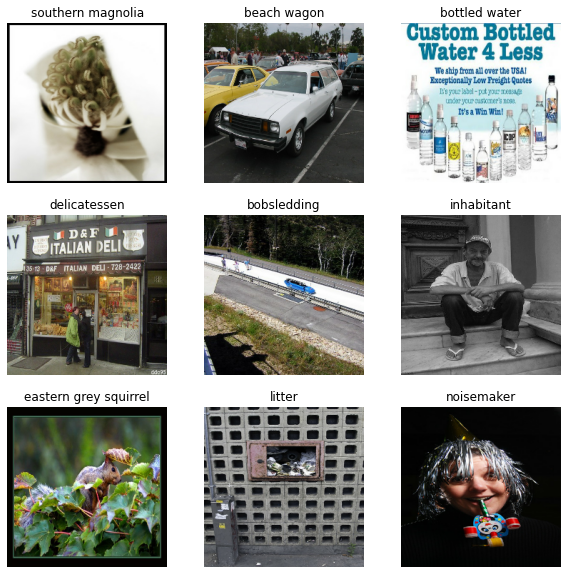

In [9]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

### Dual Stream ResNet Architecture

In [18]:
class DualStream_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None):
        super().__init__()
        self.n_outputs =  n_outputs

        self.magno_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        
        self.parvo_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.magno_stream.trainable = False
          self.parvo_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.fc_out = tf.keras.layers.Dense(self.n_outputs, activation='softmax')

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        start_time = time.time()
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)
        print("delta_time:",time.time()-start_time)

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)
        
        p_stream = self.parvo_stream(concat_gray_input)
        p_stream = self.flat(p_stream)
        
        avg_outputs = self.avg([p_stream,m_stream])
        return self.fc(avg_outputs)

In [22]:
FREEZE = False 
LOAD_WEIGHTS = None #One of None or imagenet
dual_stream_model = DualStream_ResNet(50,batch_size,FREEZE,load_type=LOAD_WEIGHTS)
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [23]:
checkpoint_path = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_ResNet"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 2)
dual_stream_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_ResNet")

Epoch 1/30
delta_time: 0.00264739990234375
delta_time: 0.002590179443359375
176/489 [=========>....................] - ETA: 13:22 - loss: 14.9797 - accuracy: 0.0192

KeyboardInterrupt: ignored

In [5]:
#Load Model:
dual_stream_model = tf.keras.models.load_model("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_ResNet")

In [ ]:
dual_stream_model.evaluate(val_ds_preprocessed)

### DualStream EfficientNet Architecture
(limitation: it causes Colab to crash when it takes too much RAM)

In [ ]:
import tensorflow as tf

class DualStream_ENet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True):
        super().__init__()
        self.n_outputs =  n_outputs

        self.magno_stream = tf.keras.applications.EfficientNetB0(
                            include_top=False,
                            weights="imagenet",
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=self.n_outputs,
                            classifier_activation="softmax",
                            )
        
        self.parvo_stream = tf.keras.applications.EfficientNetB0(
                            include_top=False,
                            weights="imagenet",
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=self.n_outputs,
                            classifier_activation="softmax",
                            )
        if freeze:
          self.magno_stream.trainable = False
          self.parvo_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.fc_out = tf.keras.layers.Dense(self.n_outputs, activation='softmax')

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)

        m_stream = self.magno_stream(color_input)
        m_stream = self.flat(m_stream)
        
        p_stream = self.parvo_stream(concat_gray_input)
        p_stream = self.flat(p_stream)
        
        avg_outputs = self.avg([p_stream,m_stream])
        return self.fc(avg_outputs)

In [ ]:
FREEZE = False #One of None or imagenet
dual_stream_model = DualStream_ENet(50,batch_size,FREEZE)
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
dual_stream_model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data = val_ds_preprocessed, 
                                      epochs= 10, callbacks=callback)
dual_stream_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Models/Dualstream_with_EfficientNet")

### Exploring different types of architecture:

In [ ]:
#VGG architecture with no pre-loaded weights

out_classes = 10

Magno_VGG_16 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten()
])

Parvo_VGG_8 = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten()
])

fc_end = Sequential([
    Average(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=out_classes, activation="softmax")
])